# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-10"

## Introduction

Normalize data and create embeddings for the each time point fraction

In [2]:
timepoint <- "T7"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_119_120/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

In [6]:
comp=15

### First clustering to localize doublets

In [7]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30389
Number of edges: 1049656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9727
Number of communities: 8
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30389
Number of edges: 1049656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9600
Number of communities: 10
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30389
Number of edges: 1049656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9496
Number of communities: 12
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30389
Number of edges: 1049656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9410
Number of communities: 16
Elapsed time: 6 seconds
Modularit

In [8]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

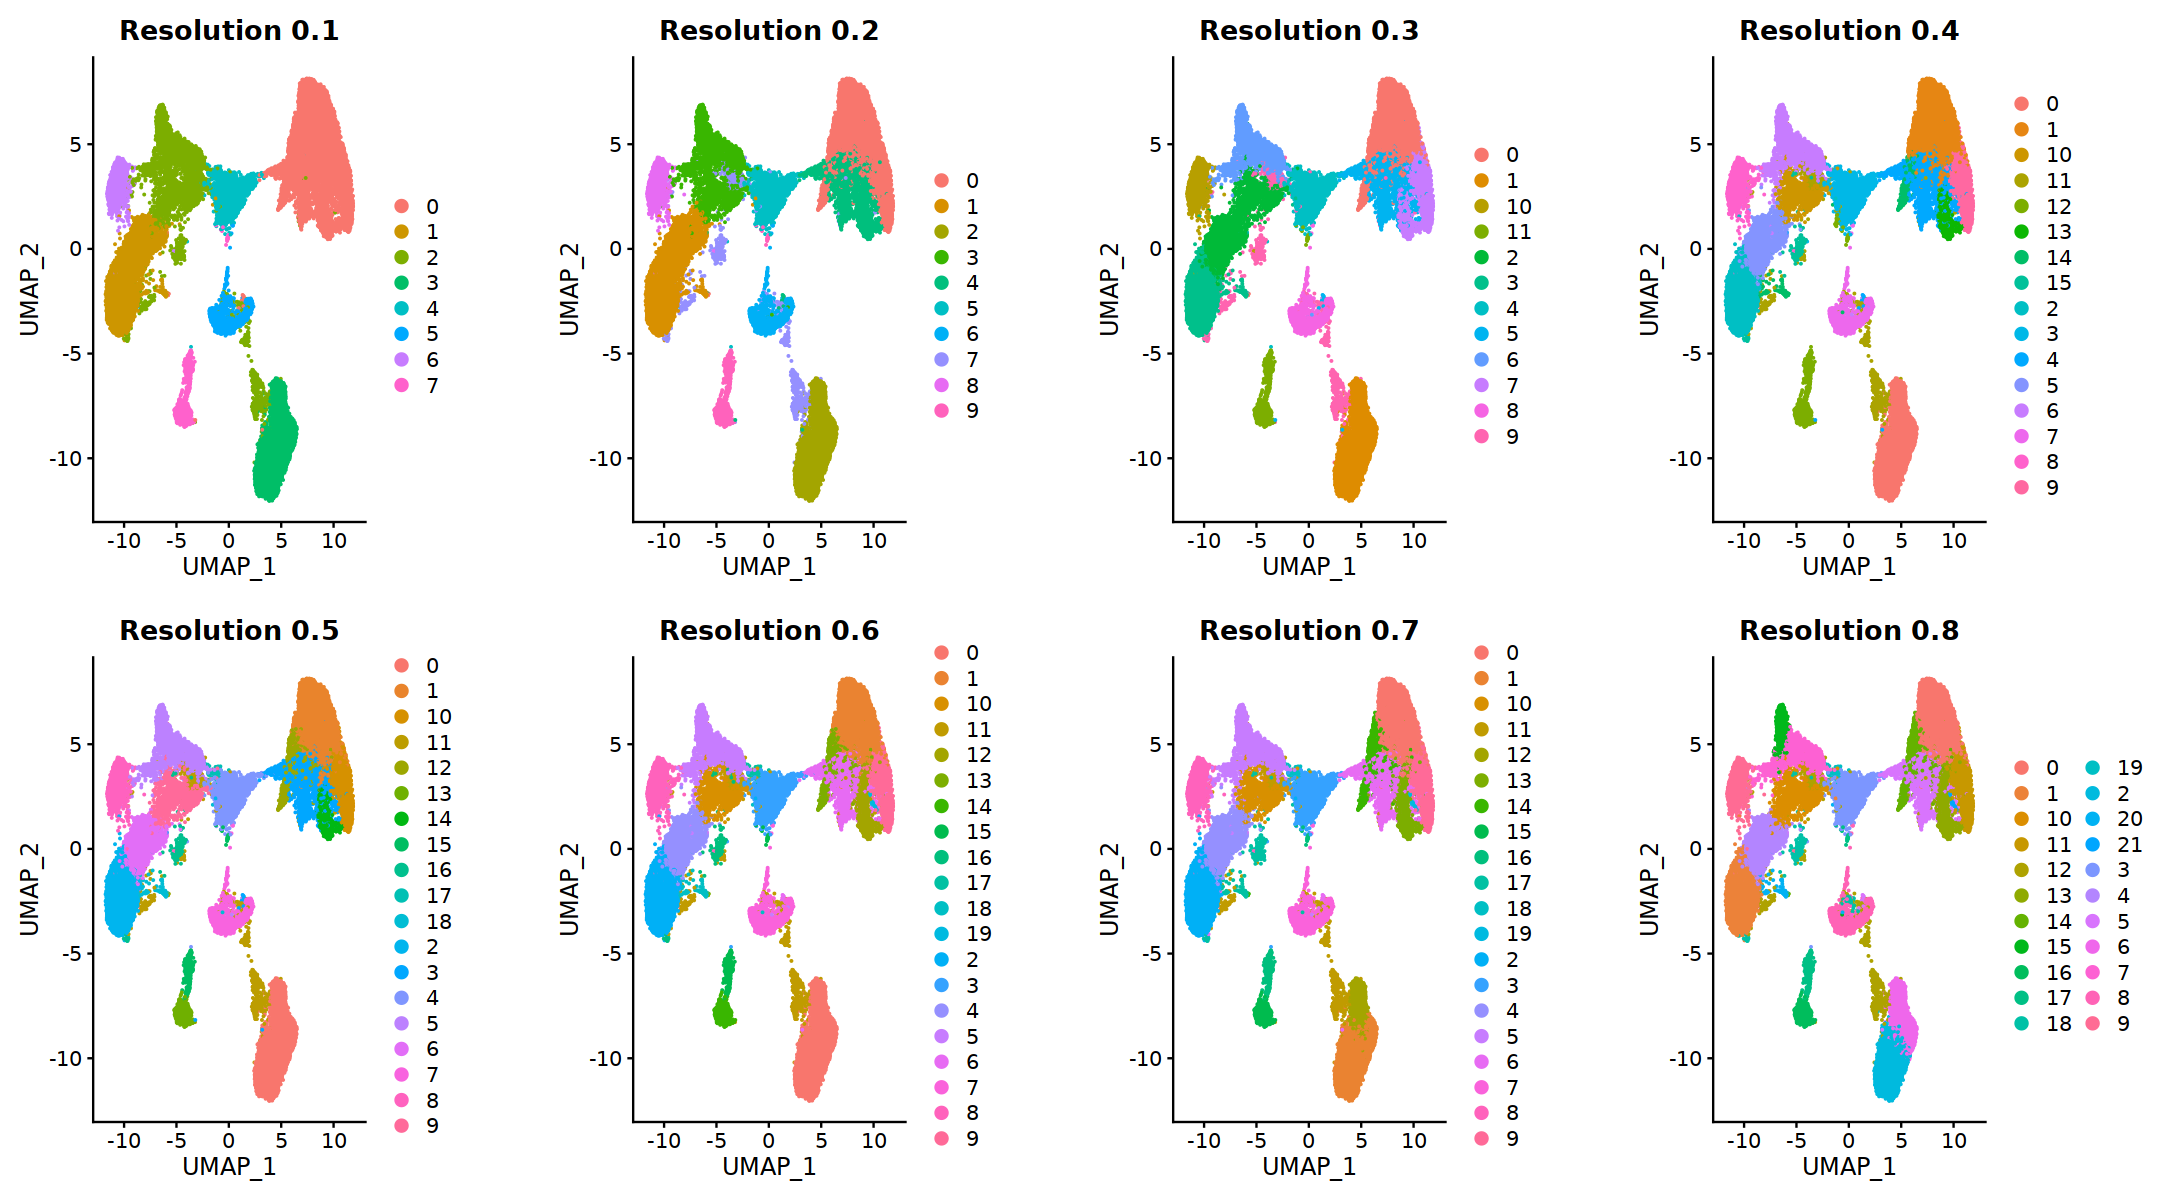

In [9]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [10]:
reso=0.3

In [11]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30389
Number of edges: 1049656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9496
Number of communities: 12
Elapsed time: 6 seconds


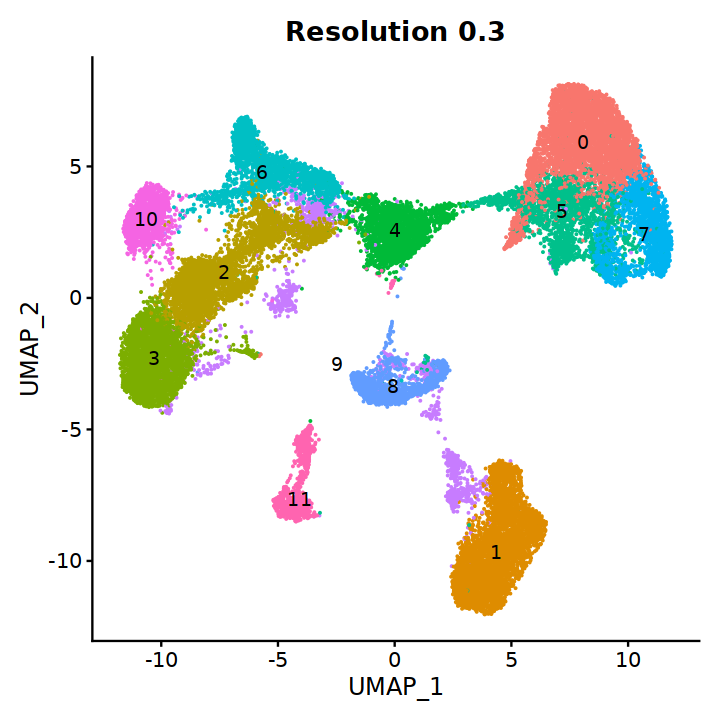

In [12]:
options(repr.plot.width = 6, repr.plot.height =6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [13]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, logfc.threshold = 0.1, 
                              random.seed=0, max.cells.per.ident=1000,
                              only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [14]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [15]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","CD4", "CD8A","NCAM1","KLRD1","FCGR3A",
             "CD14", "CD68", 
             "S100A8", "SPP1", "CD163", "MSR1",
             "HBB")

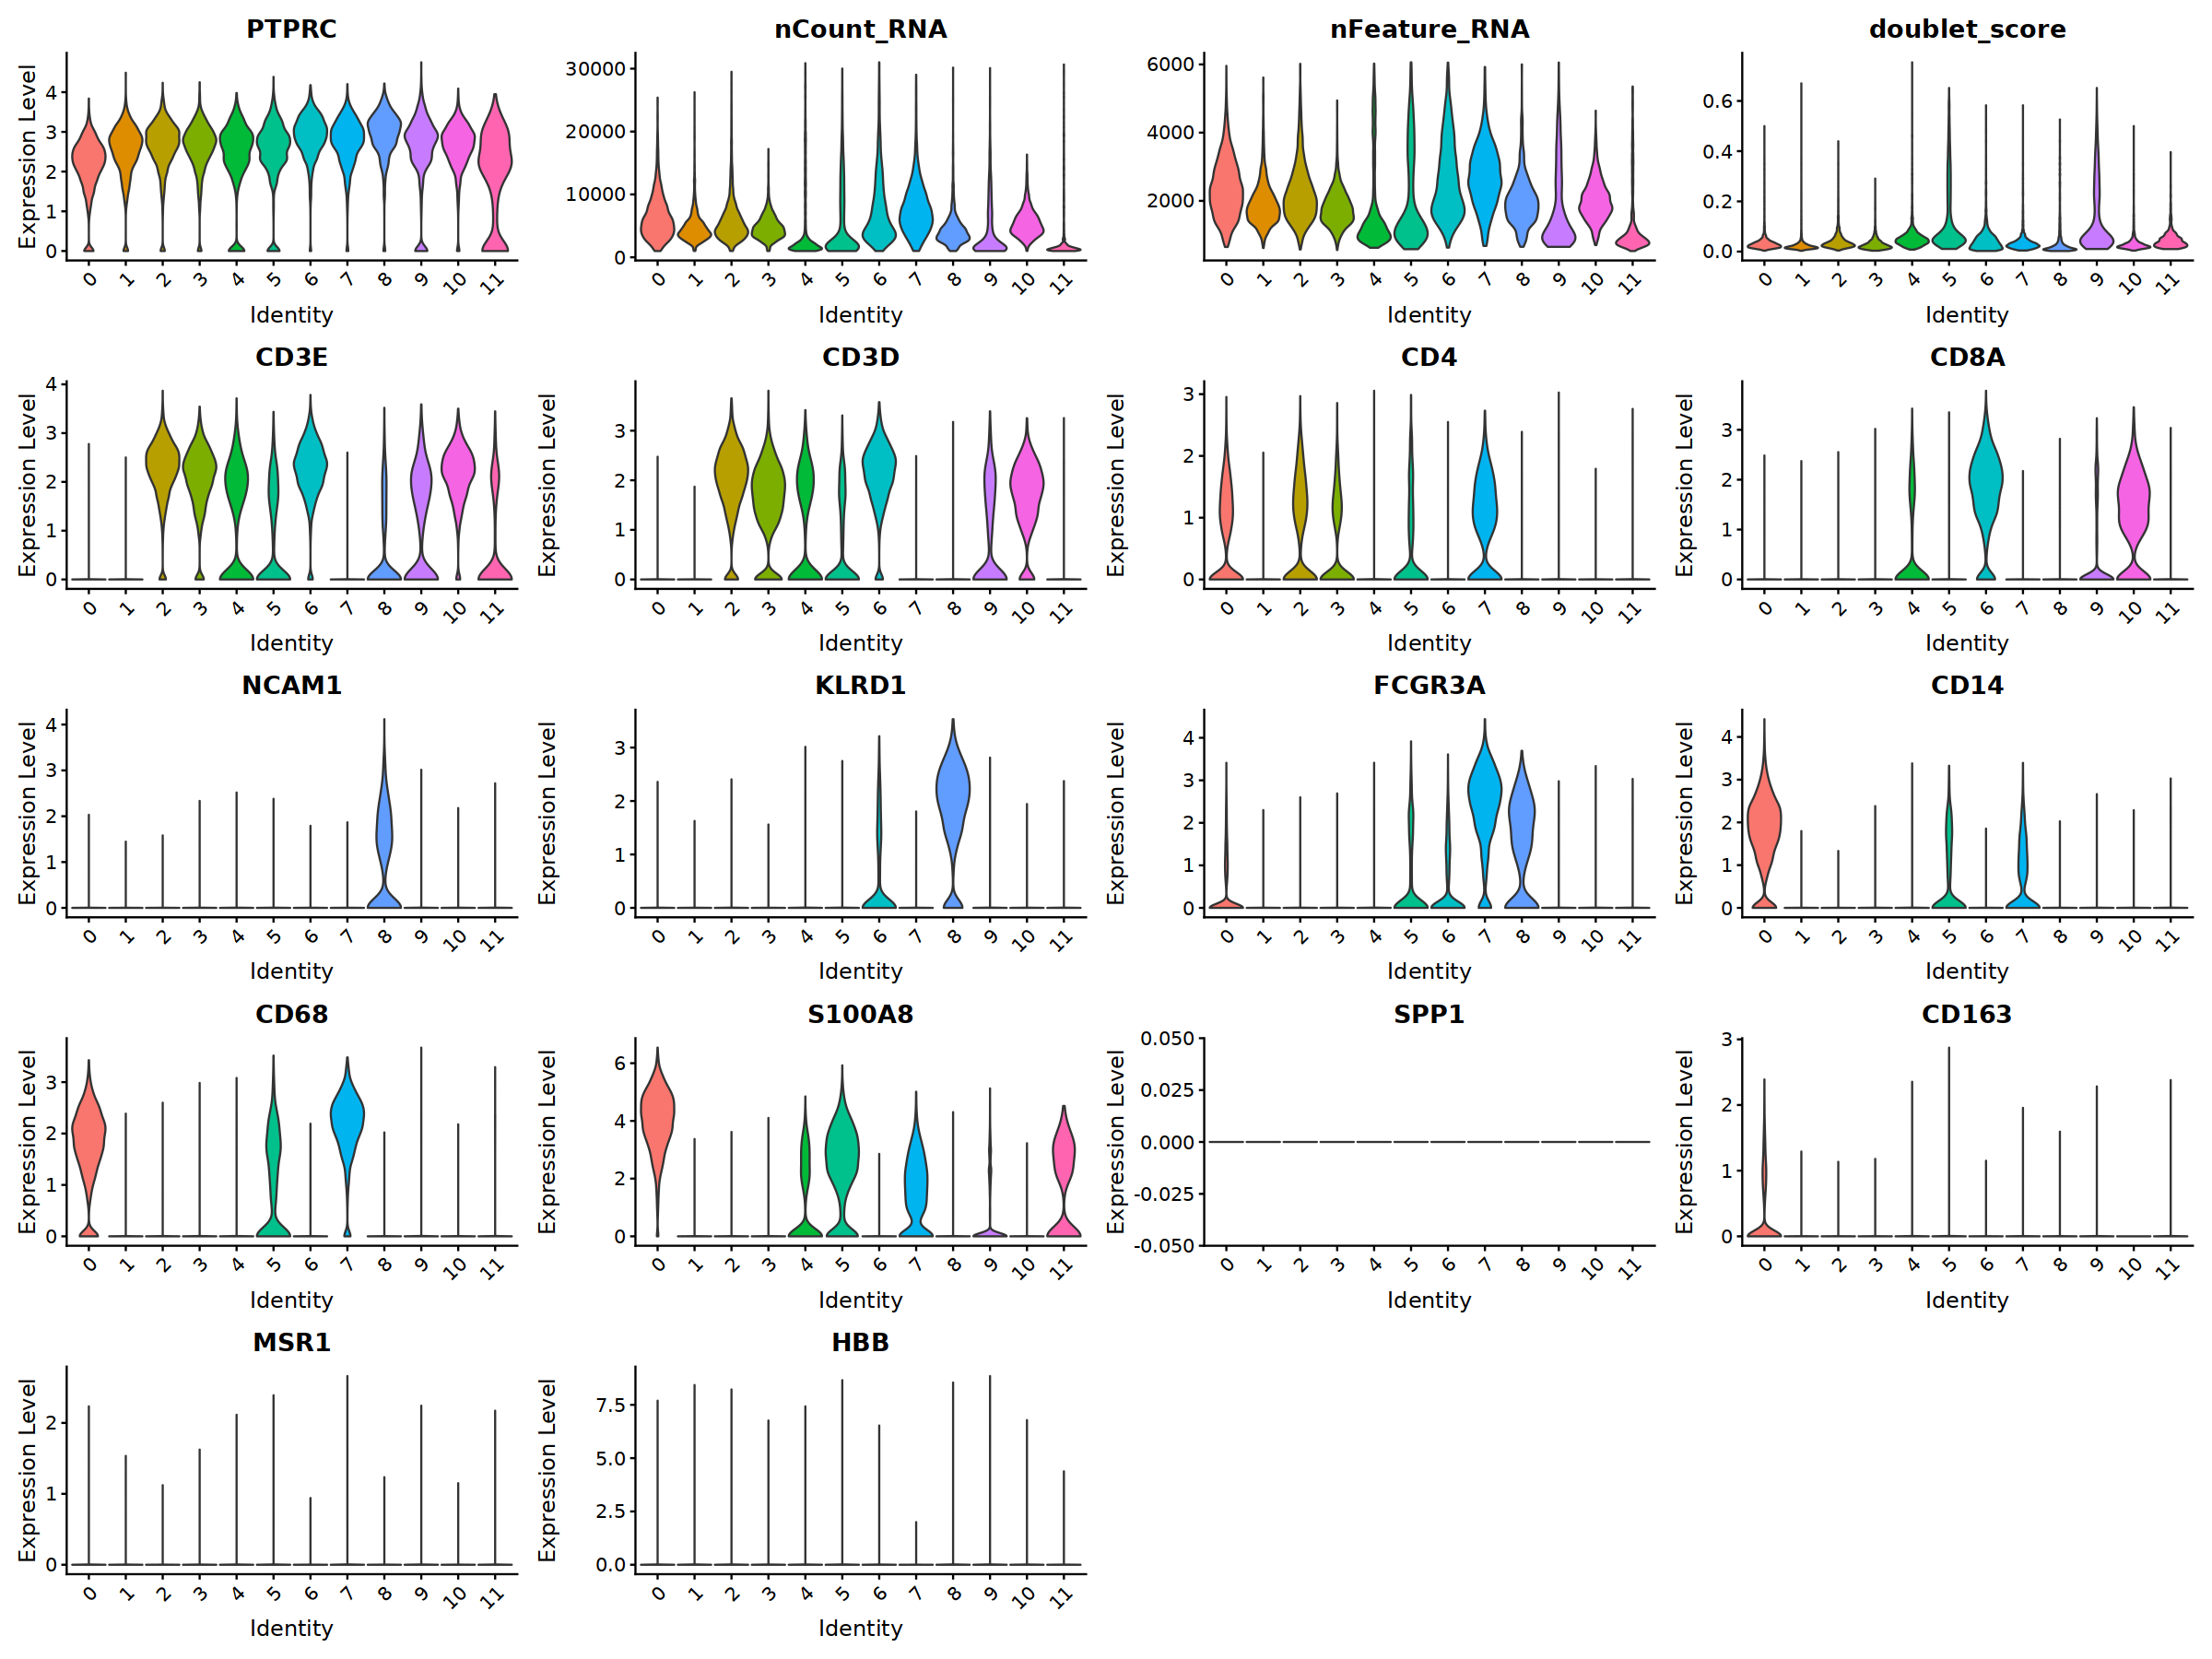

In [16]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

In [17]:
# options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
# FeaturePlot(seurat_obj, ncol=4,
#             feature=markers)

Clusters to filter out

In [18]:
c <- 5
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CST31,1.246693e-100,1.1257235,0.840,0.313,3.697193e-96,5,CST3
KIF5C1,2.296269e-33,1.0072129,0.447,0.221,6.809815e-29,5,KIF5C
SLC8A11,2.288267e-51,0.9389186,0.602,0.232,6.786085e-47,5,SLC8A1
AC011446.21,5.467086e-24,0.9230293,0.213,0.063,1.621319e-19,5,AC011446.2
AL138963.42,4.500008e-34,0.9147441,0.666,0.495,1.334522e-29,5,AL138963.4
PLXDC21,4.658967e-52,0.8628819,0.608,0.242,1.381663e-47,5,PLXDC2
VCAN1,2.602541e-56,0.8551939,0.655,0.237,7.718097e-52,5,VCAN
PSAP1,2.289334e-88,0.8475774,0.958,0.726,6.789250e-84,5,PSAP
NAMPT1,1.479855e-46,0.8059481,0.768,0.480,4.388657e-42,5,NAMPT


In [19]:
c <- 9
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
MTRNR2L122,2.855002e-56,1.0258492,0.982,0.944,8.466794e-52,9,MTRNR2L12
PRKCH4,4.073681e-24,0.9448101,0.677,0.484,1.208091e-19,9,PRKCH
MT-ND64,1.990538e-30,0.9196666,0.815,0.719,5.903141e-26,9,MT-ND6
KIF5C2,6.565594e-22,0.9048225,0.387,0.233,1.947092e-17,9,KIF5C
RORA4,4.259477e-12,0.8247928,0.426,0.290,1.263191e-07,9,RORA
TGFBR34,1.225665e-12,0.8198321,0.338,0.216,3.634831e-08,9,TGFBR3
AL138963.43,3.982215e-14,0.8088724,0.589,0.505,1.180966e-09,9,AL138963.4
RASA34,7.656732e-11,0.8067610,0.602,0.530,2.270680e-06,9,RASA3
MT-ATP84,7.243978e-19,0.7816023,0.818,0.813,2.148274e-14,9,MT-ATP8


### Remove cells

In [20]:
seurat_obj <- subset(seurat_obj, idents=c(5,9), invert=TRUE)

In [21]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
28946   710 


An object of class Seurat 
28946 features across 26411 samples within 1 assay 
Active assay: RNA (28946 features, 0 variable features)
 4 dimensional reductions calculated: pca, umap, pca_filt, harmony

## Re-do embedding and clustering

In [22]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [23]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 28946 26411 
metadata(0):
assays(2): counts logcounts
rownames(28946): AL627309.1 AL627309.5 ... AC136612.1 AC007325.2
rowData names(0):
colnames(26411): T7_1_AAACCTGAGAGCCTAG-1 T7_1_AAACCTGAGAGTACCG-1 ...
  T7_2_TTTGTCATCCATGAAC-1 T7_2_TTTGTCATCCCTAACC-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(4): PCA UMAP PCA_FILT HARMONY
mainExpName: RNA
altExpNames(0):

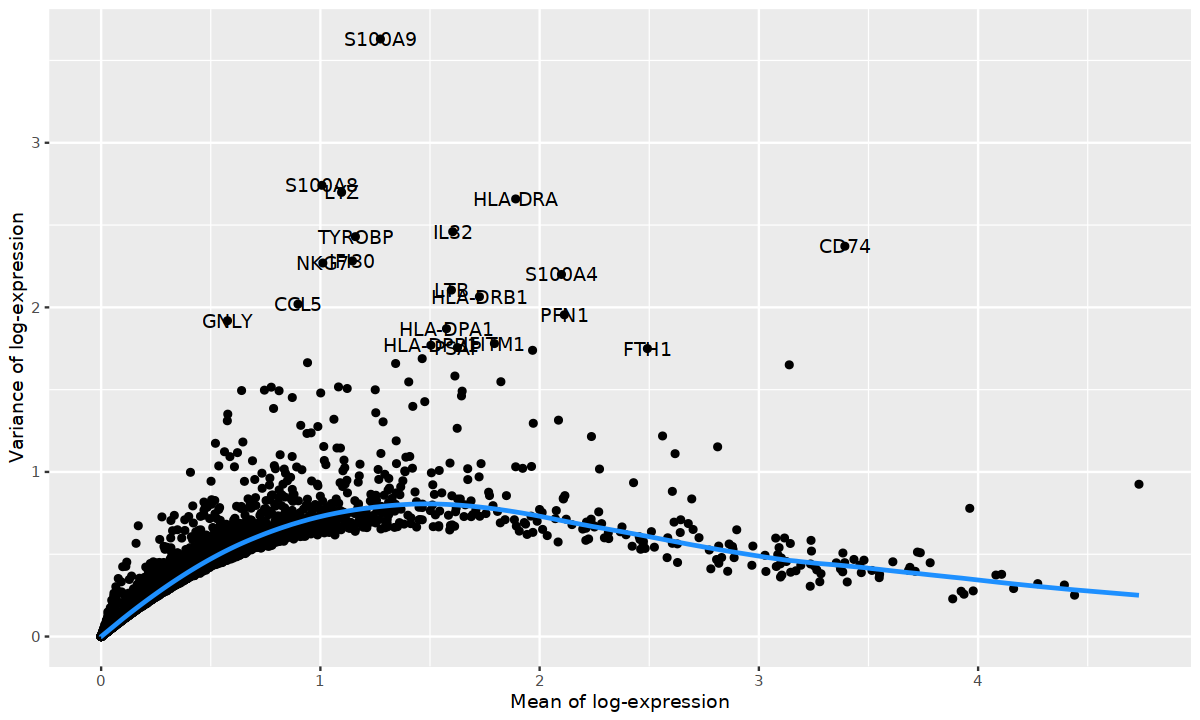

In [24]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [25]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1051

In [26]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 951

In [27]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  CD69, MALAT1, LTB, SKAP1, IFITM1, PCED1B-AS1, CD3E, CXCR4, IL32, BACH2 
	   CD3D, CD7, CD247, PRKCH, CAMK4, TCF7, IL7R, BCL2, LEF1, AFF3 
	   GZMA, CD79A, CTSW, CST7, NELL2, KLRK1, CD52, PRF1, MS4A1, RALGPS2 
Negative:  FCN1, LYZ, IFI30, SERPINA1, S100A9, TYROBP, LST1, PLXDC2, FTL, AIF1 
	   CD68, SPI1, CST3, S100A8, MNDA, NCF2, PLAUR, SLC8A1, FCER1G, CTSS 
	   PSAP, MS4A6A, CLEC7A, DMXL2, DUSP6, GRN, FGL2, RBM47, TYMP, NAMPT 
PC_ 2 
Positive:  IL32, CD247, PRKCH, CD3E, NKG7, GZMA, CD3D, IFITM1, GAPDH, CST7 
	   CD7, CCL5, PRF1, SRGN, CTSW, ANXA1, TGFBR3, S100A4, GZMB, GZMH 
	   SH3BGRL3, SKAP1, FGFBP2, IL2RB, GNLY, ACTG1, CAMK4, PCED1B-AS1, S100A10, KLRK1 
Negative:  BANK1, CD79A, MS4A1, RALGPS2, FCRL1, NIBAN3, AFF3, PAX5, CD79B, EBF1 
	   TCL1A, LINC00926, IGHM, HLA-DQA1, CD22, IGHD, RUBCNL, BLK, VPREB3, PLEKHG1 
	   CD19, MEF2C, CD83, HLA-DRA, GNG7, FCER2, TCF4, HLA-DQB1, COL19A1, FCRLA 
PC_ 3 
Positive:  IL7R, TCF7, LEF1, LTB, BC

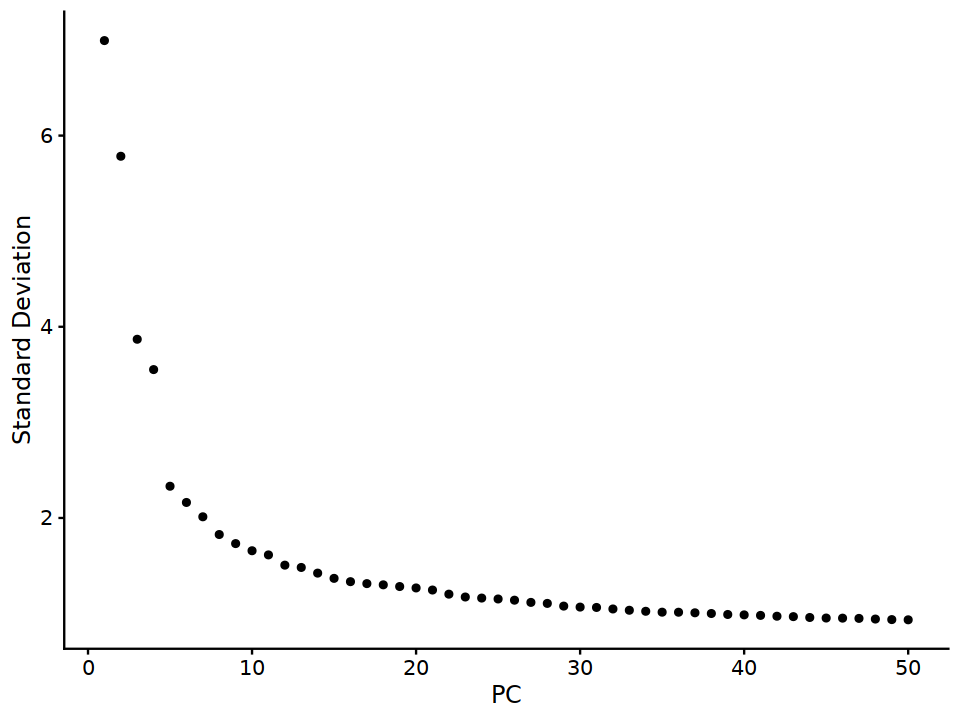

In [28]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [29]:
comp=15

In [30]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

11:19:45 UMAP embedding parameters a = 0.9922 b = 1.112

11:19:45 Read 26411 rows and found 15 numeric columns

11:19:45 Using Annoy for neighbor search, n_neighbors = 30

11:19:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:19:47 Writing NN index file to temp file /scratch_tmp/33943067/RtmpWF2dbb/file2cfc612a18f99

11:19:47 Searching Annoy index using 1 thread, search_k = 3000

11:19:56 Annoy recall = 100%

11:19:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:19:59 Initializing from normalized Laplacian + noise (using irlba)

11:20:02 Commencing optimization for 200 epochs, with 1108936 positive edges

11:20:31 Optimization finished



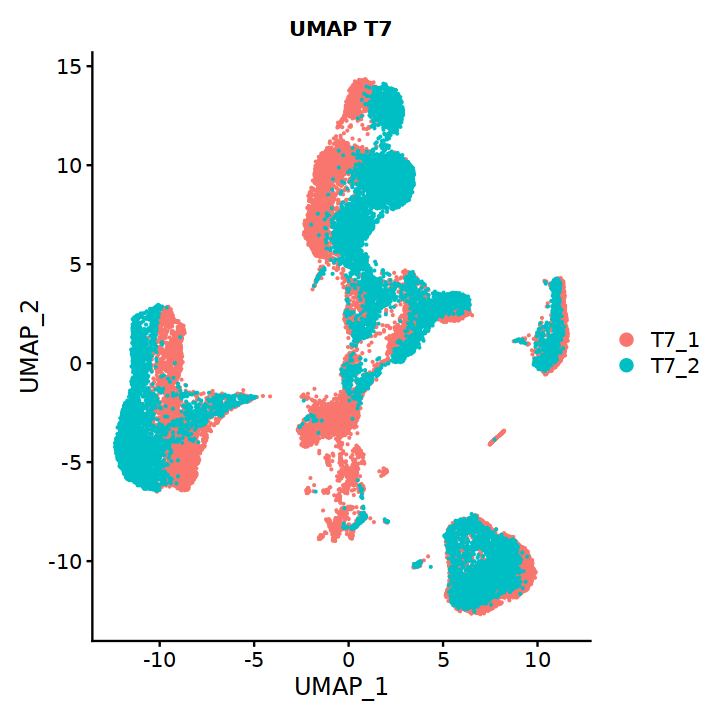

In [31]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [32]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [33]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

11:20:59 UMAP embedding parameters a = 0.9922 b = 1.112

11:20:59 Read 26411 rows and found 15 numeric columns

11:20:59 Using Annoy for neighbor search, n_neighbors = 30

11:20:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:21:02 Writing NN index file to temp file /scratch_tmp/33943067/RtmpWF2dbb/file2cfc6622138d9

11:21:02 Searching Annoy index using 1 thread, search_k = 3000

11:21:11 Annoy recall = 100%

11:21:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:21:14 Initializing from normalized Laplacian + noise (using irlba)

11:21:16 Commencing optimization for 200 epochs, with 1123948 positive edges

11:21:45 Optimization finished



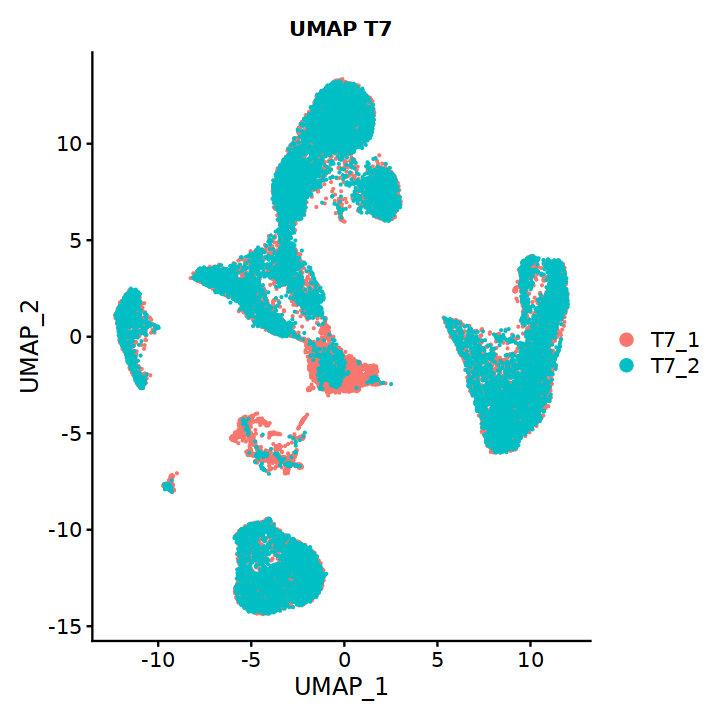

In [34]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

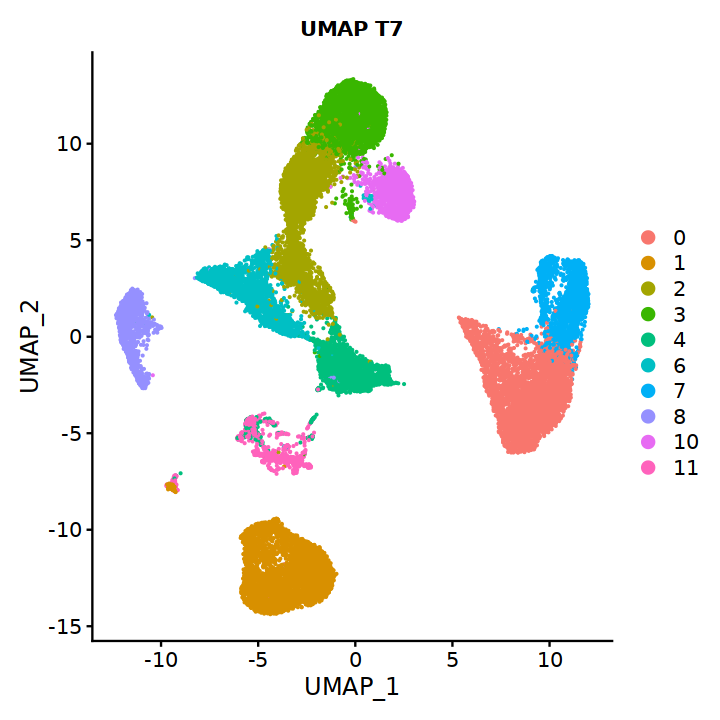

In [35]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [36]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)

Computing nearest neighbor graph

Computing SNN



In [37]:
reso = 0.3

In [38]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26411
Number of edges: 912855

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9544
Number of communities: 13
Elapsed time: 5 seconds


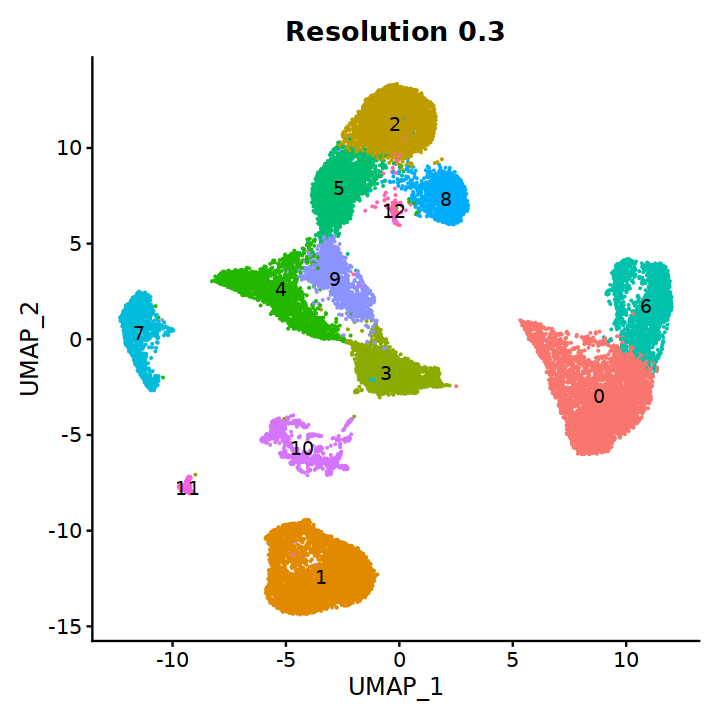

In [39]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [40]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



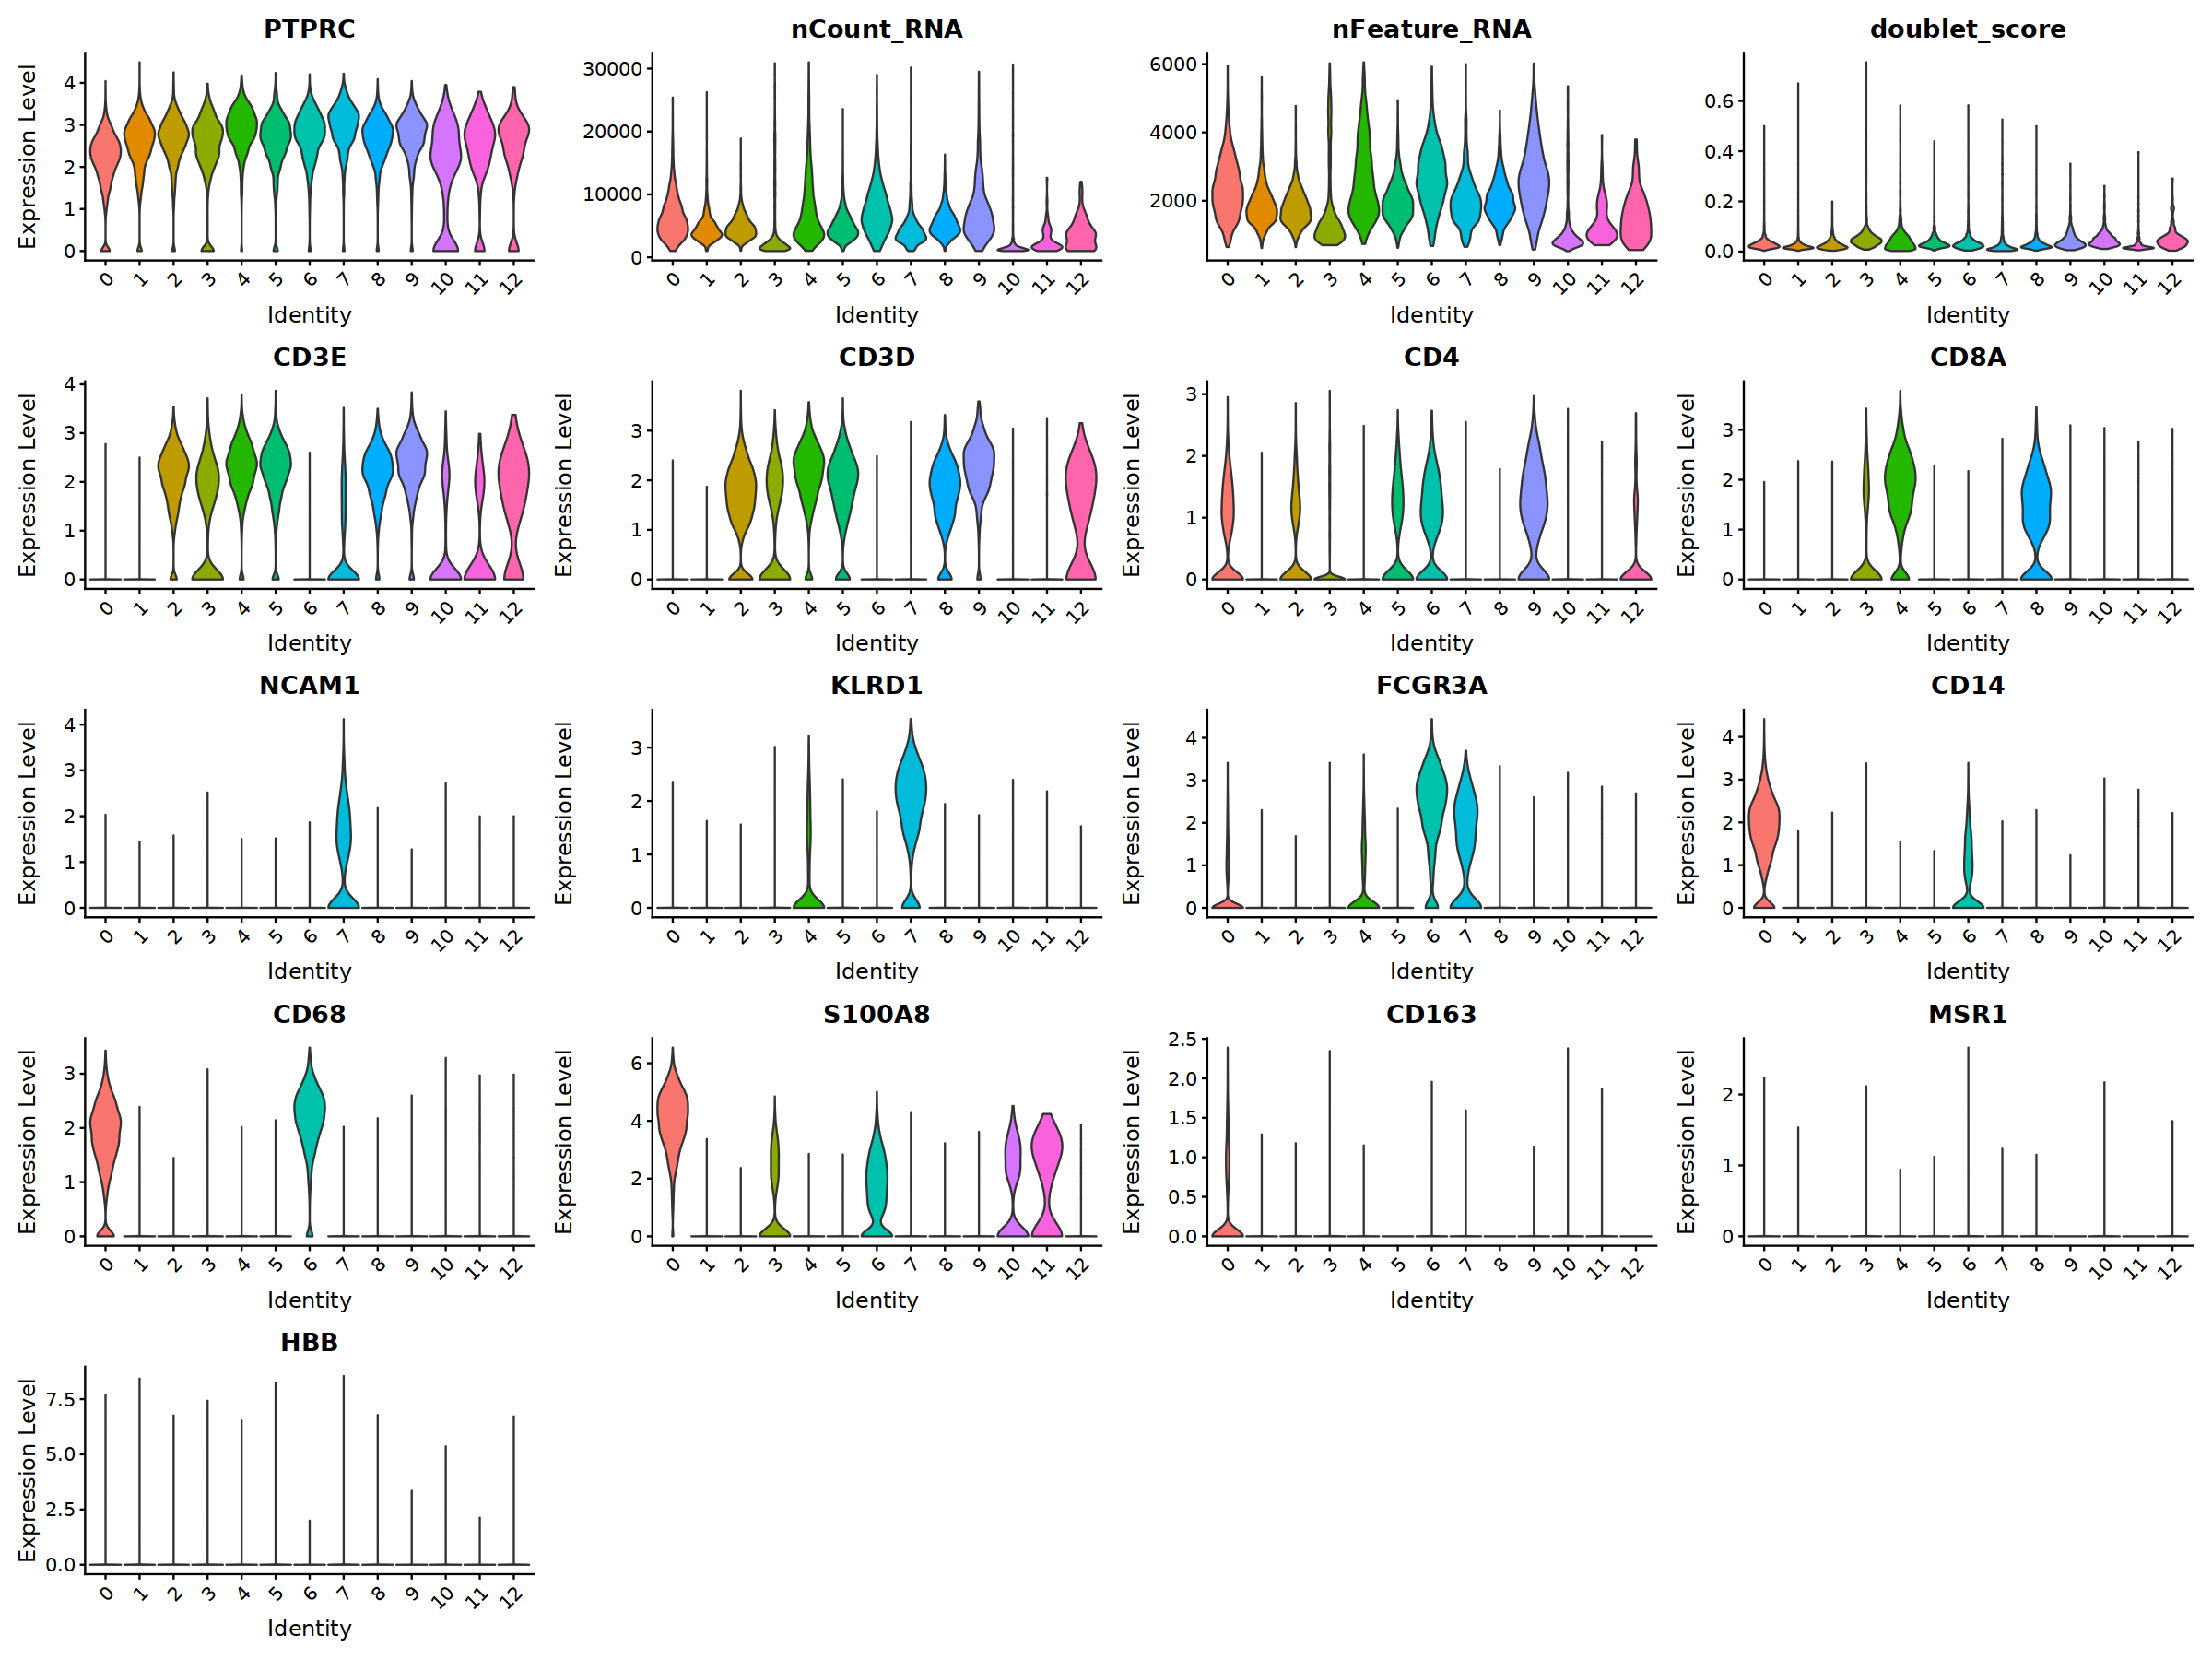

In [41]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

In [42]:
# options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
# FeaturePlot(seurat_obj, ncol=4,
#             feature=markers)

# Save

In [43]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [44]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [45]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_